In [1]:
import pandas as pd
import numpy as np
# import guidedlda
import time

from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string

"""BQ imports"""
from google.cloud import bigquery
client = bigquery.Client()

from itertools import chain
from collections import Counter

In [2]:
train = pd.read_pickle("./data/preprocess_mnet_train.pkl")

train.drop_duplicates('natid', keep='first', inplace=True)
train.reset_index(drop=True, inplace=True)

print(train.shape)
train.head()

(10078, 8)


,natid,pub_date,category,tier1,tier2,summary,clean_summary,label
0,blogandpostid/blog/post/50808-607eda2d97a5b000...,2021-04-20,Personal Finance,Real Estate,Real Estate Renting and Leasing,WeWork To Accept Crypto—And Will Pay Its Landl...,wework accept crypto pay landlords crypto. top...,7
1,blogandpostid/blog/post/4587-60d354bc9690ca000...,2021-06-23,Food and Drink,Travel,Travel Type,Celebrate The Lodge At Woodloch’s 15-Year Anni...,celebrate lodge woodloch's 15-year anniversary...,23
2,blogandpostid/blog/post/3113-5f526f97559f59000...,2020-09-04,Music and Audio,Music and Audio,Hip Hop Music,Cardi B And Megan Thee Stallion Both Earn Thei...,cardi b megan thee stallion earn no. 1 hit you...,12
3,blogandpostid/blog/post/5259-6015f002c7824f000...,2021-02-09,Travel,Shopping,Gifts and Greetings Cards,Valentine’s Day Gift Guide: The Most Romantic ...,valentine's day gift guide: romantic hotel pac...,13
4,blogandpostid/blog/post/4983-5f8064d69a4142000...,2020-10-14,Shopping,Shopping,Sales and Promotions,The Best Prime Day Bike Deals For Saving Big o...,best prime day bike deals saving big bicycles ...,13


In [3]:
train.tier1.value_counts()

Business and Finance        445
Personal Finance            442
News and Politics           442
Technology & Computing      440
Sports                      438
Medical Health              436
Video Gaming                422
Travel                      414
Science                     406
Automotive                  404
Style & Fashion             403
Events and Attractions      402
Careers                     398
Shopping                    395
Food & Drink                392
Music and Audio             388
Real Estate                 381
Education                   376
Movies                      369
Television                  343
Healthy Living              339
Home & Garden               328
Hobbies & Interests         314
Family and Relationships    302
Fine Art                    226
Pets                        152
Books and Literature        148
Pop Culture                 133
Name: tier1, dtype: int64

In [4]:
test = pd.read_pickle("./data/preprocess_mnet_test.pkl")
test.drop_duplicates('natid', keep='first', inplace=True)
test.reset_index(drop=True, inplace=True)

print(test.shape)
test.head()

(1258, 8)


,natid,pub_date,category,tier1,tier2,summary,clean_summary,label
0,blogandpostid/blog/post/3541-60eb91d76f189c000...,2021-07-12,Movies,Movies,Indie and Arthouse Movies,What Will The Movie Industry Look Like After C...,movie industry look like covid?. movie industr...,2
1,blogandpostid/blog/post/7380-5f7a952000e768000...,2020-10-05,Video Gaming,Video Gaming,Video Game Genres,A YouTuber Made An ‘Among Us’ Mode In ‘Overwat...,youtuber us' mode overwatch' looks fantastic. ...,10
2,blogandpostid/blog/post/50373-5fcfe6475a1f9400...,2020-12-08,News and Politics,News and Politics,Politics,Rudy Giuliani Says He’s ‘Doing Fine’ With Covi...,"rudy giuliani says fine' covid, hopes released...",0
3,blogandpostid/blog/post/25-607d3d189d9fd30006d...,2021-04-19,Technology and Computing,Personal Finance,Personal Investing,Will Apple Stock’s Q2 Results Beat Consensus?....,apple stock's q2 results beat consensus?. appl...,21
4,blogandpostid/blog/post/6937-60b6f3feff8c53000...,2021-06-02,Movies,Movies,Documentary Movies,Ava DuVernay’s Array Film Collective Partners ...,ava duvernay's array film collective partners ...,2


In [5]:
test.tier1.value_counts()

News and Politics           50
Personal Finance            50
Technology & Computing      50
Medical Health              50
Events and Attractions      50
Education                   50
Careers                     50
Sports                      50
Real Estate                 50
Travel                      50
Video Gaming                50
Business and Finance        50
Movies                      49
Television                  49
Healthy Living              49
Music and Audio             49
Science                     49
Shopping                    49
Automotive                  49
Style & Fashion             49
Family and Relationships    49
Food & Drink                48
Hobbies & Interests         48
Home & Garden               47
Fine Art                    25
Pets                        17
Books and Literature        17
Pop Culture                 15
Name: tier1, dtype: int64

In [3]:
start = time.time()

sql = """
       # pull tier_1 from mnet_iab
   WITH content_iab AS (   
       SELECT * FROM (
            SELECT 
                naturalId AS iab_natid, 
                RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent,
                tier1
            FROM `api-project-901373404215.Content.mnet_iab_categories` where tier1 IS NOT NULL
            ) 
        WHERE mostrecent = 1
    ),

    # Get the natid and the corresponding title form the main content table
    content AS (
        SELECT 
        natid AS content_natid,
        EXTRACT(DATE FROM date_et) AS pub_date,
        title, 
        body
        FROM (
        SELECT DISTINCT
          LOWER(NaturalId) AS natid,
          DATETIME(date, "America/New_York") as date_et,
          RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent,
          title, 
          body
        FROM
          `api-project-901373404215.Content.content`
        WHERE
          Visible is true
          AND type in (
          'blog',
          'blogslide',
          'magazine')
          )
        WHERE mostrecent = 1
    )

    # Join the content iab table with the main content table to get the articles with the iab category
      SELECT
        * 
        EXCEPT(iab_natid)
      FROM
        content
      LEFT JOIN
        content_iab
      ON
        LOWER(iab_natid) = LOWER(content_natid)
    """
df = client.query(sql).to_dataframe()
print("Shape: ", df.shape) 
print("query time (mins) - ", round((time.time() - start)/60, 2)) 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_22967/1563360839.py", line 53, in <module>
    df = client.query(sql).to_dataframe()
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/job/query.py", line 1434, in to_dataframe
    query_result = wait_for_query(self, progress_bar_type)
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/_tqdm_helpers.py", line 65, in wait_for_query
    return query_job.result()
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/job/query.py", line 1266, in result
    super(QueryJob, self).result(retry=retry, timeout=timeout)
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/job/base.py", line 679, in result
    return super(_AsyncJob, self).result(timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/site-packag

TypeError: object of type 'NoneType' has no len()

In [3]:
df.tier1.value_counts()

Business and Finance        445
Personal Finance            442
News and Politics           442
Technology & Computing      440
Sports                      438
Medical Health              436
Video Gaming                422
Travel                      414
Science                     406
Automotive                  404
Style & Fashion             403
Events and Attractions      402
Careers                     398
Shopping                    395
Food & Drink                392
Music and Audio             388
Real Estate                 381
Education                   376
Movies                      369
Television                  343
Healthy Living              339
Home & Garden               328
Hobbies & Interests         314
Family and Relationships    302
Fine Art                    226
Pets                        152
Books and Literature        148
Pop Culture                 133
Name: tier1, dtype: int64

In [6]:
import re
import html.parser
import unicodedata

# --- DEFINE VARIABLES ---

contraction_dict_file = './data/contraction_dictionary.pkl'
# Load Contraction Dictionary
c_dict = pd.read_pickle(contraction_dict_file)
# Compile the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))


# --- DEFINE FUNCTIONS ---

# Function to expand contractions
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

# Function to remove unicode
def normalize_unicode(input_str):
    '''
    replaces accents by converting to byte literal and then decoding to utf-8
    '''
    nfkd_form = unicodedata.normalize('NFKD', input_str) 
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode("utf-8")  

# Function to remove the html
class HTMLTextExtractor(html.parser.HTMLParser):
    def __init__(self):
        super(HTMLTextExtractor, self).__init__()
        self.result = []
    def handle_data(self, d):
        self.result.append(d)
    def get_text(self):
        return ''.join(self.result)

def html_to_text(html):
    s = HTMLTextExtractor()
    s.feed(html)
    return s.get_text()

def remove_html(text):
    text = str(text)
    string = re.sub('<[^<]+?>', ' ', text)
    string = html_to_text(string)
    string = re.sub('’', "'", string) 
    # [^\x00-\x7F]+ searches for all non-ASCII values
    string = re.sub(r'[^\x00-\x7F]+', ' ', string)
    # below escapes special characters mentioned inside []
    string = re.sub(r'\[.*?\]', ' ', string) 
    string = string.replace('\r', '  ')
    string = string.replace('\n', '  ')
    string = re.sub(' +', ' ', string)
    return string

def remove_newline(string):
    #remove carriage return
    string = string.replace('\r', '') 
    #remove newline
    return string.replace('\n', '') 

* Pre-process article text

In [7]:
stopwords_list = stopwords.words('english')
punctuations = list(set(string.punctuation))
unwanted_list = punctuations + stopwords_list

def clean_df(df):
    '''
    Applies above text cleaning functions and returns a df with cleaned text
    '''

    # Remove html, normalize unicode
    df['clean_body'] = df['summary'].astype(str).str.lower()
    df['clean_body'] = df['clean_body'].apply(remove_newline).astype(str)
    df['clean_body'] = df['clean_body'].apply(expandContractions, c_re=c_re)
    df['clean_body'] = df['clean_body'].apply(normalize_unicode)
    df['clean_body'] = df['clean_body'].apply(remove_html).str.strip()
    df['clean_body'] = df['clean_body'].apply(lambda x: re.sub(r"<[^>]*>", " ", x)) 
    df['clean_body'] = df['clean_body'].apply(lambda text: ' '.join([x.lower() for x in word_tokenize(text) if x.lower() not in unwanted_list and len(x)>1]))
    
    # remove numbers
    df['clean_body'] = df['clean_body'].apply(lambda text: re.sub('[0-9]+', '', text))
    # remove more than 1 space in between words 
    df['clean_body'] = df['clean_body'].replace('\s+', ' ', regex=True) 
    
    return df

In [8]:
# clean train

train = clean_df(train)
train.shape #2mins 

(10078, 9)

In [9]:
# clean test

test = clean_df(test)
test.shape

(1258, 9)

In [13]:
from nltk import pos_tag

# Contraction dictionary
STOP_WORDS = pd.read_pickle('./data/forbes_stop_words.pkl')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(x) for x in text]
    text = [x for x in text if len(x) > 1]
    
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    # tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(text) if is_noun(pos)] 
    
    # return text
    return ' '.join(all_nouns)

In [11]:
# process-noun train

train['processed_noun'] = train['clean_body'].apply(clean_text) #3mins

In [12]:
# process-noun test

test['processed_noun'] = test['clean_body'].apply(clean_text) 

In [14]:
train.clean_summary.str.len().describe().astype(int)

count    10078
mean      3592
std       2133
min        433
25%       2227
50%       3149
75%       4326
max      30344
Name: clean_summary, dtype: int64

In [15]:
train.processed_noun.str.len().describe().astype(int)

count    10078
mean      1727
std       1034
min        210
25%       1058
50%       1516
75%       2105
max      14969
Name: processed_noun, dtype: int64

* LDA:
    * LDA calculates a probability p(t|w) = probability of topic t given word w. At it’s core it’s just Bayesian_probability. <br><br>
        
* Guided LDA
    * The idea was to set some seed words for Space and Tech. Then guide the model to converge around those terms.
    * We can control this parameter of how much extra boost should be given to a ter using seed_confidence and it can range between 0 and 1

In [ ]:
# 9/21/21 
# idea - for every tier2 category - for every article, get top 5 words combine to tier2 like "business music industry etc"

In [50]:
# defining priors

automotive = ['automotive', 'car', 'driver', 'vehicle', 'truck', 'engine', 'wheel', 
                                 'roadway', 'ride', 'ev']

career =  ['career', 'workforce', 'interview', 'skill', 'job', 'talent', 'candidate', 
                              'promotion', 'hiring', 'employer']

education = ['education', 'enrollment', 'degree', 'professor','school', 'course', 'university', 
                                'college', 'faculty', 'campus']

family = ['family', 'children', 'mother', 'nurse', 'custody', 'teenager', 'marriage', 
                             'baby', 'care', 'children']

food = ['food', 'cuisine', 'restaurant', 'meat', 'lunch', 'drink', 'wine', 
                           'menu',  'whisky', 'champagne']

medical = ['medical', 'health', 'virus', 'brain', 'cancer', 'patient', 'vaccine', 
                              'vaccination', 'cases', 'variant']

movies = [ 'movie', 'film', 'theater', 'box', 'character', 'sequel', 'release',  
                             'comedy', 'marvel', 'disney']

news_politics = ['news', 'politics', 'house', 'bill', 'president', 'election', 'democrat', 
                                    'government', 'police','republican']

personalf = ['bank', 'savings', 'borrower', 'payment', 'irs', 'loan', 'taxes', 'earning',
                                'student', 'retirement']

realestate = ['real', 'rent', 'property', 'estate',  'listing', 'landlord', 'home',
                                 'farm', 'housing', 'mortgage']

music = ['music', 'song', 'chart', 'album', 'band', 'radio', 'hit',  
                            'musician', 'bts', 'billboard']

travel = ['travel', 'tent', 'suite', 'cruise', 'resort', 'airport', 'stay',  
                             'guest', 'hotel', 'flight']

video_game = ['video', 'creed', 'outriders', 'fortnite', 'cyberpunk', 'trilogy', 'herokiller', 
                                 'nintendo', 'ps5', 'gaming']

healthy_living = ['healthy', 'vitamin', 'therapy', 'workout', 'fitness', 'meditation', 'habit',  
                                     'body', 'mindfulness', 'wellness']

pets = ['pets', 'animals', 'dogs', 'conservation', 'bats', 'parrot', 'bird', 
                           'species', 'cats', 'vet']

tech = ['technology', 'computing', 'app', 'server', 'software', 'camera', 'data', 
                           'laptop', 'users', 'machine']

sports = ['sports', 'champions', 'coach', 'athletes', 'tournament', 'league', 'football', 
                             'basketball', 'wwe', 'tennis']

bf = ['business', 'finance', 'consumer', 'trade', 'capital', 'currency', 'companies', 
                         'stock', 'earning', 'quarter']

In [ ]:
# incomplete
# manual_ctfidf_noun_books = ['book', 'literature', 'story', 'author', 'storyteller', 'children books', 'inspired']

# manual_ctfidf_noun_events_attrac = ['events', 'attractions', 'party', 'parks', 'museum', 'festival', 'disneyland',
#                                    'announcement']

# manual_ctfidf_noun_fine_art = ['art', 'photographer', 'studio',]

# manual_ctfidf_noun_hobbies = ['hobby', 'guitar', 'beekeepers']

# manual_ctfidf_noun_home = ['garden', 'furniture', 'kitchen', 'trash', ]

# manual_ctfidf_noun_science = ['science', 'scientist', 'planet', 'climate change',  'environment', 'spacecraft']

# manual_ctfidf_noun_shopping = ['shopping', 'buy', 'gift', 'price', 'deal', 'spending', 'shop']
                                     
# manual_ctfidf_noun_style = ['style', 'fashion', 'exhibition', 'beauty', 'skincare', 'botox', 'gold', 'brand']

# manual_ctfidf_noun_television = ['television', 'adaptation', 'show', 'series', 'subscribers', 'drama','episode', 
#                                  'season',]

In [ ]:
corpus = df.clean_body.tolist()
vocab = list(set(word_tokenize(" ".join(df.clean_body))))
vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=vocab)
X = vectorizer.fit_transform(corpus)
word2id = vectorizer.vocabulary_

In [51]:
seed_topic_list = [automotive, career, education, family, food, medical, movies, news_politics, personalf, realestate, music,
                   travel, video_game, healthy_living, pets, tech, sports, bf] 
len(seed_topic_list)

18

In [32]:
model = guidedlda.GuidedLDA(n_topics=18, n_iter=2000, random_state=7, refresh=20, alpha=0.01, eta=0.01)

In [52]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [53]:
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15) #7.30

INFO:guidedlda:n_documents: 1258
INFO:guidedlda:vocab_size: 52066
INFO:guidedlda:n_words: 641900
INFO:guidedlda:n_topics: 18
INFO:guidedlda:n_iter: 2000
INFO:guidedlda:<0> log likelihood: -8289204
INFO:guidedlda:<20> log likelihood: -6247764
INFO:guidedlda:<40> log likelihood: -6104775
INFO:guidedlda:<60> log likelihood: -6049198
INFO:guidedlda:<80> log likelihood: -6014628
INFO:guidedlda:<100> log likelihood: -5992891
INFO:guidedlda:<120> log likelihood: -5977226
INFO:guidedlda:<140> log likelihood: -5966835
INFO:guidedlda:<160> log likelihood: -5955429
INFO:guidedlda:<180> log likelihood: -5948466
INFO:guidedlda:<200> log likelihood: -5940079
INFO:guidedlda:<220> log likelihood: -5934263
INFO:guidedlda:<240> log likelihood: -5928833
INFO:guidedlda:<260> log likelihood: -5921636
INFO:guidedlda:<280> log likelihood: -5915350
INFO:guidedlda:<300> log likelihood: -5912498
INFO:guidedlda:<320> log likelihood: -5906438
INFO:guidedlda:<340> log likelihood: -5900466
INFO:guidedlda:<360> log 

In [54]:
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))


Topic 0: driving car cars self electric vehicles ai road vehicle human
Topic 1: work people working women time team family employees pandemic help
Topic 2: students university college school black education schools colleges january women
Topic 3: one like time even would people get also first way
Topic 4: food wine whisky restaurant skin best sweet products new made
Topic 5: covid 19 health vaccine care pandemic said new cases people
Topic 6: film million disney movie story series character films black star
Topic 7: said trump president biden forbes states key court election would
Topic 8: student loan tax income child property financial pay plan would
Topic 9: light earth space moon universe said beach could dark study
Topic 10: music first one new song album wwe top chart also
Topic 11: new art home hotel city collection inspired york fashion guests
Topic 12: apple deals save amazon black deal tv new best shop
Topic 13: best mattress price also space air desk set made bike
Topic 14: 

In [ ]:
# todo: map these 17 converged topics to tier-labels

In [56]:
# topic_num_name = {"Topic 0":"automotive",
#                   "Topic 1":"career",
#                   "Topic 2":"education",
#                   "Topic 3":"",
#                   "Topic 4":"food",
#                  "Topic 5":"medical",
#                  "Topic 6":"movies",
#                  "Topic 7":"news_politics",
#                  "Topic 8":"personal_finance",
#                  "Topic 9":"",
#                  "Topic 10":"music",
#                  "Topic 11":"travel",
#                  "Topic 12":"family",
#                  "Topic 13":"shopping",
#                  "Topic 14":"family",
#                  "Topic 15":"tech",
#                  "Topic 16":"sports",
#                  "Topic 17":"business_finance",}    

#  realestate, travel, video_game, healthy_living, pets, tech, 

In [57]:
def get_doc_topics(model_glda,X,num_topics,dataframe,col_name):
    """
    A function which creates dataframe with documents, their dominant topic, along with their probabilities
    
    Parameters
    -------------
    model_glda - Guided LDA trained model
    X - Document term frequency table
    num_topics - Number of topics the model was trained for
    dataframe - Dataframe consisting of cleaned text column
    col_name - Column name in dataframe holding cleaned text
    
    Returns
    -------------
    A dataframe with document number, topic, probability of topic
    """
    df_doc_top = pd.DataFrame()
    final_list = []
    for index in range(len(dataframe[col_name])):
        word_id_dict = dict((x,y) for x,y in zip([x for x in range(num_topics)],np.round(model.transform(X[index])*100,1).tolist()[0]))
        word_score_list = []
        for index in range(num_topics):
            try:
                value = word_id_dict[index]
            except:
                value = 0
            word_score_list.append(value)
        final_list.append(word_score_list)

    df_doc_top = pd.DataFrame(final_list)
    df_doc_top.columns = ['Topic ' + str(i) for i in range(num_topics)]
    df_doc_top.index = ['Document ' + str(i) for i in range(len(dataframe[col_name]))]

    df_doc_top["Dominant_Topic"] = df_doc_top.idxmax(axis=1).tolist()
    df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
    document_df = df_doc_top.reset_index().rename(columns={"index":"Document"})[["Document","Dominant_Topic","Topic_Probability"]]

    return document_df

In [ ]:
# todo: try to get top 3 topic probability - not just 1

In [59]:
# feed new data to get label predictions

document_df = get_doc_topics(model, X, 28, df, "clean_summary")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [60]:
document_df

,Document,Dominant_Topic,Topic_Probability
0,Document 0,Topic 3,29.9
1,Document 1,Topic 3,45.5
2,Document 2,Topic 7,49.2
3,Document 3,Topic 17,61.0
4,Document 4,Topic 6,29.0
...,...,...,...
1253,Document 1253,Topic 9,36.0
1254,Document 1254,Topic 3,63.0
1255,Document 1255,Topic 12,55.6
1256,Document 1256,Topic 5,51.7


<AxesSubplot:>

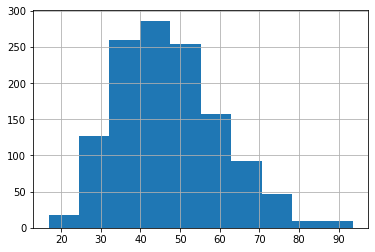

In [62]:
document_df.Topic_Probability.hist()

In [ ]:
# todo: visualize pyldavis 

# todo: analyze results

# concern - unstable, not suitable for prod, generating data ok